
I implement basic text pre-procssing and then define and train the Glove model.

My codes are evaluated based on

*   Correct and reasonable text preprocessing.
*   Convergence of the model training.
*   Interesting word embedding shown by visualization and word similarity.
*   Speeding up of the word indexing and model training.



In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/research/Datasets/Amazon_UCSD')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/research/Datasets/Amazon_UCSD
 assignment2	     glove_model_22.pt
 best_model.pt	     glove_model_23.pt
 comatrix.pkl	     glove_model_24.pt
 glove_model_0.pt    glove_model_2.pt
 glove_model_10.pt   glove_model_3.pt
 glove_model_11.pt   glove_model_4.pt
 glove_model_12.pt   glove_model_5.pt
 glove_model_13.pt   glove_model_6.pt
 glove_model_14.pt   glove_model_7.pt
 glove_model_15.pt   glove_model_8.pt
 glove_model_16.pt   g

## Text Preprocessing and Dataset Construction

### Define the WordIndexer class to
*   hold the mapping from words to their indices and the indices to words.
*   fit_transform to map from a list of sentences to a list of integers so that words are mapped to their indices, in the input order.

### Inherit from the `torch.utils.data.Dataset` class and create the AmazonReviewGloveDataset class to


*   load the Amazon reviews in the csv format. Tokenize the reviews into sentences (a review can contain more than one sentence).
*   use the WordIndexer class to obtain the indices of the words in the sentences.
*   compute the X (word co-occurrence) matrix as the Glove paper indicates.

We provide the function to read the pretrained word vectors from text files.

In [2]:
import re
from collections import Counter
import pickle

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

class WordIndexer:
    """Transform a dataset of text to a list of index of words."""

    def __init__(self, min_word_occurences=10, oov_word="OOV"):
        """ min_word_occurrences: integer, the minimum frequency of the word to keep.
            oov_word: string, a special string for out-of-vocabulary words.
        """
        self.oov_word = oov_word
        self.min_word_occurences = min_word_occurences
        self.word_to_index = {oov_word: 0}
        self.index_to_word = [oov_word]
        self.word_occurrences = {}
        self.re_words = re.compile(r"\b[a-zA-Z]{2,}\b")

    def get_word_index(self, word, add_new_word = True):
        """ Find the index of a word.
                
            word: string, the query word.
            add_new_word: if true, if the word has no entry, assign a new integer index to word.
                            if false, return the index of the oov_word
        """
        try:
            return self.word_to_index[word]
        except KeyError:
            if add_new_word:
                idx = len(self.word_to_index)
                self.word_to_index[word] = idx
                self.index_to_word.append(word)
            else:
                idx = self.word_to_index[self.oov_word]
            return idx

    @property
    def n_words(self):
        """ return: the vocabulary size
        """
        return len(self.word_to_index)

    def fit_transform(self, texts, use_existing_indexer = False):
        """ texts: list of sentences, each of which is a string
            use_existing_indexer: if true, don't create new indexer
            
            Split each sentence into a list of words.
            Then filter out the infrequent words.
            Other text preprocessing, such as
                lower-casing,
                stop-word removal, and
                advance word tokenization
                are possible here.
            Lastly setup the word-to-index and index-to-word dictionaries.
            
            return: a list of lists of indices of words in each sentence.
                    For example: [[1,2,3], [4,5,6]] where,
                        [1,2,3] are the indices of words in the first sentence
                        [4,5,6] are the indices of words in the second sentence
                    
        """
        # list of lists of words. Lower-casing and tokenization happen here.
        stopset = set(stopwords.words('english'))
        l_words = []
        for sentence in texts:
            tokens = word_tokenize(sentence.lower())
            tokens = [w for w in tokens if not w in stopset]
            final_tokens = []
            for w in tokens:
                w = self.re_words.findall(w)
                if len(w) > 0:
                    final_tokens.append(w[0])
            l_words.append(final_tokens)
        print (f'number of sentences: {len(l_words)}')
#         l_words = [list(self.re_words.findall(sentence.lower()))
#                    for sentence in texts]
        
        # this happens when a training corpus has been processed and you're processing
        # the validation and test corpora
        if use_existing_indexer:
            return [[self.get_word_index(word, add_new_word=False)
                     for word in words]
                    for words in l_words]
        
        # keep the unique words and their counts
        word_occurrences = Counter(word for words in l_words for word in words)
        
        with open('./train_word_counts.txt', 'w') as out_f:
            a = sorted([(word, count) for word, count in word_occurrences.items()],
                   key = lambda x:x[1], reverse=True)
            for word, count in a:
                out_f.write('{}:{}\n'.format(word, count))
                

        # a dictionary of key=word, value=number of occurrences
        # filter out the infrequent ones.
        self.word_occurrences = {
            word: n_occurences
            for word, n_occurences in word_occurrences.items()
            if n_occurences >= self.min_word_occurences}

        oov_index = 0
        
        # register the frequent unique words in the word2index and index2word dictionaries
        return [[self.get_word_index(word)
                 if word in self.word_occurrences else oov_index
                 for word in words]
                for words in l_words]
    
class AmazonReviewGloveDataset(Dataset):
    def __init__(self, path, indexer = None, right_window = 4, min_word_occurences = 10):
        """ Load the reviews from a csv file. One row is one review.
                See train_small.csv for the format.
                
            path: path to the csv file containing the reviews and their ratings
            indexer: if None, build a new WordIndexer, otherwise use the one passed in.
            right_window: integer, how large the window is to get context words.
            min_word_occurrences: integer, the minimum frequency of the word to keep.
        """
        self.right_window = right_window
        
        # Step 1: tokenize the first field of each row into sentences
        #         (e.g. using nltk.tokenize.sent_tokenize).
        df = pd.read_csv(path)
        texts = []
        for r in range(df.shape[0]):
            try:
                a = sent_tokenize(df.iloc[r, 0])
                texts += a
            except Exception as inst:
                pass
        print ('{} reviews loaded. {} sentences.'.format(df.shape[0], len(texts)))
        
        
        # Step 2: pass the list of all sentences to WordIndexer.
        # turn list of sentences into list of lists of word indices in the sentences.
        # Keep the word ordering.
        print ('Indexing the corpus...')
        if indexer is None:
            self.indexer = WordIndexer(min_word_occurences=min_word_occurences)
            corpus = self.indexer.fit_transform(texts, use_existing_indexer = False)
        else:
            self.indexer = indexer
            corpus = self.indexer.fit_transform(texts, use_existing_indexer = True)  
        print ('Done indexing the corpus.')
        
        
        # Step 3: go through the corpus and gather (center, context) in comatrix,
        # which is a collections.Counter object.
        # keys are (center, context) pairs
        # values are the number of their co-occurrence as defined in the Glove paper.
        print ('Constructing the co-occurrence matrix...')
        comatrix = Counter()
        for sentence in corpus:
            # for each sentence
            for i, left_index in enumerate(sentence):
                # for each position i and the corresponding word index at position i
                right_most = min(i + self.right_window + 1, len(sentence))
                
                window = sentence[i + 1: right_most]
                for distance, right_index in enumerate(window):
                    # for each context word and the distance between (center, contex)
                    comatrix[(left_index, right_index)] += 1. / (distance + 1)
                    
        with open('./comatrix.pkl', 'wb') as out_f:
            pickle.dump(comatrix, out_f)

        # linearize the entries in the co-occurrence matrix for mini-batch SGD training
        # a batch is a list of tuples (center, context, num_cooccurrences)
        self.left, self.right, self.n_occurrences = zip(*[(left, right, x) for (left, right), x in comatrix.items()])
    
        print (f'Done constructing the co-occurrence matrix. Number of entries = {len(self.left)}')
        print (self.left[0], self.right[0], self.n_occurrences[0])
        
    def __getitem__(self, index):
        return self.left[index], self.right[index], self.n_occurrences[index]
    
    def __len__(self):
        return len(self.left)
    
def load_pretrained_wv(path):
    wv = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            items = line.split(' ')
            wv[items[0]] = torch.DoubleTensor([float(a) for a in items[1:]])
    return wv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Define the Glove model
The parameters include

*   Vectors of words when used as center and context words
*   Biases for the center and contexts words.

The parameters are defined for you already and please don't change the variable names.

There is an option to pass in pre-trained word vectors to replace random initialization of the word vectors in this model.

You have to complete the forward function to compute the predictions of log X_ij.



In [0]:
from torch import nn
import torch.functional as F

class GloveModel(nn.Module):
    def __init__(self, word_indexer, wv = None, word_dims = 300, BASE_STD = 0.01, random_state = 0):
        """ Specify and initialize the parameters of the Glove network.
        """
        super(GloveModel, self).__init__()
        num_words = word_indexer.n_words
        
        torch.manual_seed(random_state)
        
        # initialize left and right word vectors
        self.L_vecs = (torch.randn((num_words, word_dims))  * BASE_STD)
        self.R_vecs = (torch.randn((num_words, word_dims))  * BASE_STD)
        
        # initialize the left and right biases 
        self.L_bias = (torch.randn((num_words, )) * BASE_STD).requires_grad_()
        self.R_bias = (torch.randn((num_words, )) * BASE_STD).requires_grad_()
        
        if wv is not None:
            num_replaced = 0
            for i in range(num_words):
                word = word_indexer.index_to_word[i]
                if word in wv:
                    num_replaced += 1
                    self.L_vecs[i] = wv[word]
                    self.R_vecs[i] = wv[word]
            print (f'Replaced {float(num_replaced) / num_words}')
            
        self.L_vecs.requires_grad_()
        self.R_vecs.requires_grad_()
        
        # gather the trainable parameters
        self.parameters = [self.L_vecs, self.R_vecs, self.L_bias, self.R_bias]
        
    def forward(self, left_indices, right_indices):
        """ Implement w_i^t w_j + b_i + b_j (the left-hand-side of Eq. (7) in the Glove paper)
        
            left_indices: torch.Tensor, a batch of center words
            right_indices: torch.Tensor, a batch of context words, of the same shape of left_indices.
            
            left_indices[i] and right_indices[i] is the i-th pair in the training data.
            
            return: torch.Tensor of the same shape of left_indices
        """
        sim = (self.L_vecs[left_indices] * self.R_vecs[right_indices]).sum(1).view(-1)
        return sim + self.L_bias[left_indices] + self.R_bias[right_indices]

## Model training, validating, and saving

### First define some constants




In [4]:
import torch
from tqdm import tqdm

# this will automatically place all tensor on GPU with type Double.
# if you are not running on GPU, change this line to
# torch.set_default_tensor_type('torch.DoubleTensor')
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

# set up a couple of parameters and hyper-parameters

NUM_EPOCH = 25
BATCH_SIZE = 512

NUM_DIMS = 300

WINDOW_SIZE = 10

# two hyper-parameters in Eq. (9) of the paper
x_max = 100
alpha = 0.75

all_train = './reviews_Cell_Phones_and_Accessories_5.csv'

train_path = './train_small.csv'
valid_path = './valid_small.csv'
test_path = './test_small.csv'

save_path = './glove_model_{}.pt'

pretrained_wv = './glove.6B.{}d.txt'.format(NUM_DIMS)
print (pretrained_wv)

./glove.6B.300d.txt


In [0]:
# load pretrained word vectors
# wv = load_pretrained_wv(pretrained_wv)

In [0]:
# print (wv['good'])

### Then define the training, validation, and test data.
*   Use the AmazonReviewGloveDataset class to read in reviews in the train, valid, test sets.
*   Have the option to read the larger csv file using the all_train.
*   Define DataLoader wrapping around the Dataset objects



In [7]:
# load text data and turn them into a DataLoader object.
train_dataset = AmazonReviewGloveDataset(train_path, right_window = WINDOW_SIZE)
train_iter = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

# use training data's word indexer for validation and test datasets
# valid_dataset = AmazonReviewGloveDataset(valid_path, train_dataset.indexer)
# valid_iter = DataLoader(valid_dataset, batch_size = BATCH_SIZE * 4, shuffle = False)

# test_dataset = AmazonReviewGloveDataset(test_path, train_dataset.indexer)
# test_iter = DataLoader(test_dataset, batch_size = BATCH_SIZE * 4, shuffle = False)

# Now run Glove on the big one
# train_dataset = AmazonReviewGloveDataset(all_train, right_window = WINDOW_SIZE)

15989 reviews loaded. 93506 sentences.
Indexing the corpus...
number of sentences: 93506
Done indexing the corpus.
Constructing the co-occurrence matrix...
Done constructing the co-occurrence matrix. Number of entries = 1592741
1 2 38.32460317460317


In [0]:
train_iter = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

### Third, start training.

*   Require to use GPU to train the network, since GPU are ubiquitous (colab or SandBox).
*   Complete the function train_and_validate.



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = GloveModel(train_dataset.indexer, wv, word_dims = NUM_DIMS)
model = GloveModel(train_dataset.indexer, word_dims = NUM_DIMS)


# make sure you use weight_decay to activate the L2 regularization
optimizer = torch.optim.Adam(model.parameters, weight_decay=1e-8)

def train_and_validate(train_iter, valid_iter = None):
    best_loss = -1
    best_epoch = -1
    to_save = {}
    
    for epoch in range(NUM_EPOCH):
        model.train()
        epoch_loss = 0
        num_batches = len(train_iter)
        for l, r, n_lr in train_iter:
            l = l.cuda()
            r = r.cuda()
            n_lr = n_lr.cuda()
            optimizer.zero_grad()
            
            # Implement the loss function in Eq. (8) of the paper, in three steps.
            # Step 1. find the prediction of log(X_ij) using the network
            predictions = model(l, r)
            
            # Step 2. compute the weights f(X_ij)
            weights = torch.div(n_lr, x_max).pow(alpha)
            weights[weights > 1] = 1.0
            
            # Step 3. compute the loss using the predictions and the weights
            loss = (torch.mul((predictions - torch.log(n_lr)) ** 2, weights)).mean()
            
            epoch_loss += loss.item()
            # gradient descent
            loss.backward()
            optimizer.step()
        print(f'Training epoch = {epoch}, epoch loss = {epoch_loss / num_batches}')
        
        # validate the model on validation set
#         with torch.no_grad():        
#             model.eval()
#             epoch_loss = 0
#             num_batches = len(valid_iter)
#             for l, r, n_lr in valid_iter:
#                 l = l.cuda()
#                 r = r.cuda()
#                 n_lr = n_lr.cuda()
#                 predictions = model(l, r)
#                 weights = torch.div(n_lr, x_max).pow(alpha)
#                 weights[weights > 1] = 1.0
#                 loss = (torch.mul((predictions - torch.log(n_lr)) ** 2, weights)).mean()
#                 epoch_loss += loss.item()
#             print(f'Validation loss = {epoch_loss / num_batches}')
            
#         cur_loss = epoch_loss / num_batches
#         if best_loss == -1 or cur_loss < best_loss:
#             best_loss = cur_loss
#             best_epoch = epoch

            # record the model state_dict() for saving later
        to_save = {
            'epoch': epoch,
            'model_state_dict': model.state_dict()
        }
        torch.save(to_save, save_path.format(epoch))
        print (save_path.format(epoch))
    # report and save the best model
#     print(f'best epoch = {best_epoch} with the best training loss = {best_loss}')
#     torch.save(to_save, save_path)
    
train_and_validate(train_iter, valid_iter = None)

Training epoch = 0, epoch loss = 0.03625864030798087
./glove_model_0.pt
Training epoch = 1, epoch loss = 0.021101806949767456
./glove_model_1.pt
Training epoch = 2, epoch loss = 0.014310158969347246
./glove_model_2.pt
Training epoch = 3, epoch loss = 0.010033987850472312
./glove_model_3.pt
Training epoch = 4, epoch loss = 0.0075060512579911845
./glove_model_4.pt
Training epoch = 5, epoch loss = 0.0059613855997570275
./glove_model_5.pt
Training epoch = 6, epoch loss = 0.004930054487794077
./glove_model_6.pt
Training epoch = 7, epoch loss = 0.004265518967560073
./glove_model_7.pt
Training epoch = 8, epoch loss = 0.003797668487883272
./glove_model_8.pt
Training epoch = 9, epoch loss = 0.0034701686460305186
./glove_model_9.pt
Training epoch = 10, epoch loss = 0.003257353761860032
./glove_model_10.pt
Training epoch = 11, epoch loss = 0.003083905406071912
./glove_model_11.pt
Training epoch = 12, epoch loss = 0.0029665890290152927
./glove_model_12.pt
Training epoch = 13, epoch loss = 0.002864

## We provide to pieces of codes to see the trained word vectors.
### Visualize the learned word vectors
### Retrieve the similar words

Use these two functionalities to see what you're model has learned.

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def load_model(save_path, indexer):
    model = GloveModel(indexer, word_dims = NUM_DIMS)

    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']

    # move the model to GPU if has one
    model.to(device)

    # need this for dropout
    model.eval()
    return model

def plot_2d(label, embeddings, words=[], a=1):
    """ Plot the word vectors projected to 2D.
        Source codes taken from:
        https://gist.github.com/sismetanin/6c2c398ec719a1958b0dc2bca653f9eb#file-tsne-word2vec-2d-anna-karenina-py
        
        embeddings: word vectors projected to 2D
        words: list of words to label the points.
    """
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

glove = load_model(save_path.format(24), train_dataset.indexer)
# avg_word_vectors = (glove.L_vecs.to('cpu') + glove.R_vecs.to('cpu')) / 2
# print (avg_word_vectors.device)
# print (avg_word_vectors.size())
# print (train_dataset.indexer.n_words)
embeddings_ak = glove.L_vecs.to('cpu').detach().numpy()

# read this article before you start visualization

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(embeddings_ak)

# tsne_ak_2d = TSNE(perplexity = 500, n_iter = 1000)
# embeddings_ak_2d = tsne_ak_2d.fit_transform(pca_result_50)

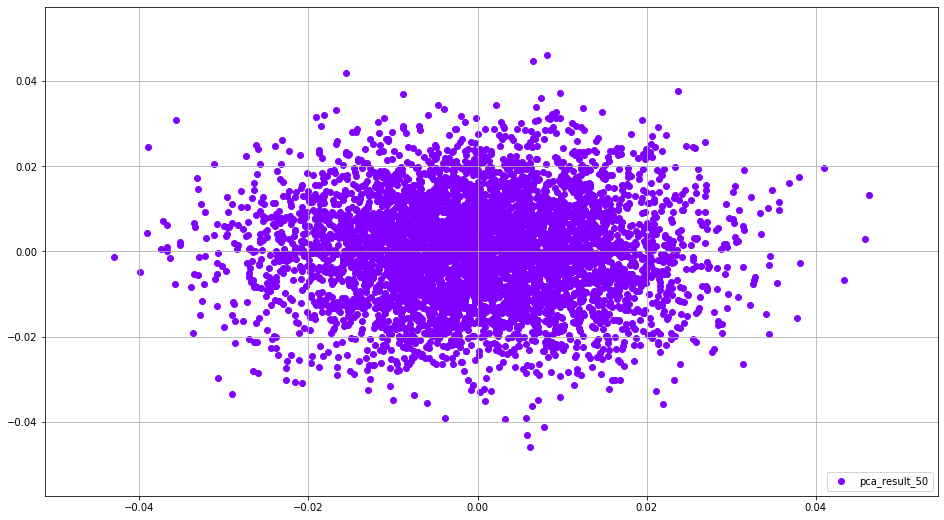

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

# with open('word_embedding_tsne_stopword', 'wb') as out_f:
#     pickle.dump(pca_50, out_f)
plot_2d('pca_result_50',pca_result_50)

## Retrieve similar words

In [15]:
from sklearn.preprocessing import normalize

test_aspect_words = ['phone', 'case', 'battery', 'headset', 'charger', 'quality', 'screen', 'bluetooth', 'price', 'device']
test_sentimental_words = ['great', 'good', 'well', 'works', 'better', 'little', 'easy', 'nice', 'new', 'long']

glove = load_model(save_path.format(0), train_dataset.indexer)
avg_word_vectors = (glove.L_vecs.to('cpu') + glove.R_vecs.to('cpu')) / 2
avg_word_vectors = avg_word_vectors.detach().numpy()

n_words = train_dataset.indexer.n_words

row_normalized = normalize(avg_word_vectors)
sim = row_normalized.dot(row_normalized.T)

for w in test_aspect_words:
    w_idx = train_dataset.indexer.word_to_index[w]
    l = []
    for i in range(n_words):
        l.append((i, sim[w_idx, i]))
    l = sorted(l, key = lambda x:x[1], reverse = True)
    for i in range(10):
        print (f'{train_dataset.indexer.index_to_word[l[i][0]]}: {l[i][1]}')
        
for w in test_sentimental_words:
    w_idx = train_dataset.indexer.word_to_index[w]
    l = []
    for i in range(n_words):
        l.append((i, sim[w_idx, i]))
    l = sorted(l, key = lambda x:x[1], reverse = True)
    for i in range(10):
        print (f'{train_dataset.indexer.index_to_word[l[i][0]]}: {l[i][1]}')

phone: 1.0000000000000004
according: 0.22616980572012352
reviewer: 0.20701141339182993
stuffed: 0.18225283288643984
opener: 0.1810873570217379
levels: 0.178331685248294
stop: 0.17796083817052388
repeatedly: 0.17577965883826185
bling: 0.1728633326936786
killed: 0.17099740423325507
case: 0.9999999999999993
hurricane: 0.19662292730381078
dect: 0.19267643177378307
redial: 0.17857758954943698
helped: 0.17668442669029752
pattern: 0.17292581501674928
appeal: 0.17040001152494805
tested: 0.16442793378541398
design: 0.16290856666886797
slow: 0.16065879299908717
battery: 1.0000000000000007
heads: 0.19063953547536922
cylinder: 0.18790005423007944
ui: 0.18295120410744237
themes: 0.18050606689275459
monitor: 0.17485696291583344
therefore: 0.1694001815753308
shack: 0.1681189593488561
walk: 0.16790550572346047
science: 0.16418852476979923
headset: 1.0000000000000004
mistake: 0.19934551493554753
forgotten: 0.1990714209098479
subtle: 0.19431898486343285
treo: 0.19238602269159627
beep: 0.1853453943336759